# **Introducción a la Reducción Dimensional**
### **¿Por qué necesitamos reducir dimensiones?**
En el análisis de datos modernos, frecuentemente nos encontramos con conjuntos de datos que tienen muchas variables (dimensiones). Por ejemplo.
- Una imagen de 28x28 píxeles tiene 784 dimensiones
- Un documento de texto puede tener miles de palabras únicas (dimensiones)
- Datos genómicos pueden tener millones de características

### **La Maldición de la Dimensionalidad**

Se refiere a varios fenómenos que ocurren cuando analizamos datos en espacios de alta dimensión:
- Esparcimiento de datos: El volumen del espacio crece exponencialmente con cada dimensión
- Distancia entre puntos: En altas dimensiones, todos los puntos tienden a estar igualmente distantes
- Necesidad de datos: El número de muestras necesarias crece exponencialmente

In [ ]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

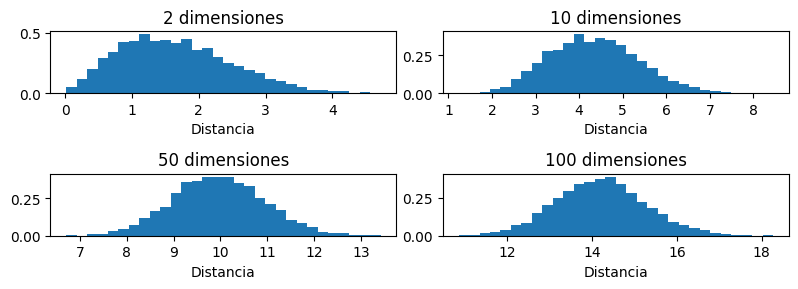

In [ ]:
# Crear datos sintéticos en diferentes dimensiones
np.random.seed(42)

def calculate_pairwise_distances(n_dimensions):
    # Generar 100 puntos en n_dimensions
    X = np.random.normal(0, 1, (100, n_dimensions))

    # Calcular distancias entre todos los pares de puntos
    distances = []
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            dist = np.sqrt(np.sum((X[i] - X[j])**2))
            distances.append(dist)
    return distances

dimensions = [2, 10, 50, 100]
plt.figure(figsize=(8, 3))

for i, dim in enumerate(dimensions):
    distances = calculate_pairwise_distances(dim)
    plt.subplot(2, 2, i+1)
    plt.hist(distances, bins=30, density=True)
    plt.title(f'{dim} dimensiones')
    plt.xlabel('Distancia')

plt.tight_layout()
plt.show()

La imagen muestra histogramas de distancias entre puntos en espacios de 2, 10, 50 y 100 dimensiones. A medida que aumenta la dimensionalidad:

- La distribución de distancias se vuelve más gaussiana (forma de campana).
- Las distancias se concentran más lejos del origen (las curvas se desplazan hacia la derecha).
- La variabilidad relativa de las distancias disminuye (los picos son más pronunciados).
- En espacios de alta dimensionalidad, los puntos tienden a estar aproximadamente a la misma distancia entre sí, lo que dificulta distinguir elementos cercanos de lejanos, afectando algoritmos basados en distancias.

## **1. Panorama General de Técnicas de Reducción Dimensional**
 Existen dos grandes categorías de técnicas.
- **Métodos Lineales**
 - PCA (Principal component analysis - Análisis de Componentes Principales)
 - Factor Analysis
 - Linear Discriminant Analysis (LDA)
- **Métodos No Lineales**
 - t-SNE (t-distributed Stochastic Neighbor Embedding)
 - UMAP (Uniform Manifold Approximation)
 - Autoencoder Neural Networks

## **2. Análisis de Componentes Principales (PCA)**
### **2.1 Fundamentos Matemáticos**
PCA es una técnica que busca encontrar las direcciones de máxima varianza en datos de alta dimensión. Matemáticamente, PCA encuentra los eigenvectores (vectores propios) de la matriz de covarianza de los datos.

**Proceso matemático del PCA**
- Centrado de datos:
 - Para cada característica $x_i$: $x_i' = x_i - \mu_i$
   
   donde $\mu_i$ es la media de la característica
- Cálculo de la matriz de covarianza:
 - $\Sigma = \frac{1}{n-1}X^TX$
  
   donde X es la matriz de datos centrada
- Descomposición en valores propios:
 - $\Sigma v = \lambda v$
   
   donde $\lambda$ son los valores propios y $v$ los vectores propios
 Veamos esto en la práctica:

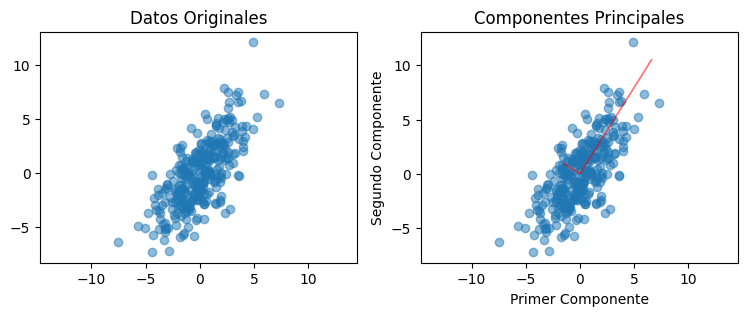

In [ ]:
# Crear datos de ejemplo
np.random.seed(42)
n_samples = 300
X = np.dot(np.random.normal(0, 1, (n_samples, 2)), [[2, 1], [1, 3]])

# Visualizar datos originales
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.title('Datos Originales')
plt.axis('equal')

# Calcular PCA manualmente
X_centered = X - X.mean(axis=0)
cov_matrix = np.cov(X_centered.T)
eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)

# Ordenar eigenvalores y eigenvectores
idx = eigenvals.argsort()[::-1]
eigenvals = eigenvals[idx]
eigenvecs = eigenvecs[:, idx]

# Visualizar componentes principales
plt.subplot(122)
plt.scatter(X_centered[:, 0], X_centered[:, 1], alpha=0.5)
for i in range(2):
    plt.arrow(0, 0,
              eigenvecs[0, i] * eigenvals[i],
              eigenvecs[1, i] * eigenvals[i],
              color='r', alpha=0.5)
plt.title('Componentes Principales')
plt.axis('equal')
plt.xlabel('Primer Componente')
plt.ylabel('Segundo Componente')
plt.show()

La imagen muestra datos originales vs. componentes Principales. Los vectores rojos en el gráfico de la derecha representan las direcciones de máxima varianza (componentes principales). PCA identifica las direcciones (componentes) que capturan la mayor variabilidad en los datos. Esto permite reducir dimensiones manteniendo la información más relevante.

### **2.2 Supuestos del PCA**
PCA tiene varios supuestos matemáticos importantes:
- Linealidad: las relaciones en los datos deben ser lineales
- Variables continuas: las variables deben ser continuas o al menos ordinales
- Correlación: debe existir algún grado de correlación entre las variables
- Outliers: PCA es sensible a valores atípicos

### **2.3 Preparación de Datos**
La preparación adecuada de los datos es crucial para PCA. Los pasos principales son:
- Estandarización: Crucial cuando las variables tienen diferentes escalas
- Manejo de valores faltantes (solo en caso de existir): Imputación o eliminación
- Tratamiento de outliers (solo en caso de existir): Eliminación o transformación

En el siguiente ejemplo se muestra un como un dataset con dos variables con diferentes escalas y valores es transformado para poder aplicar PCA.

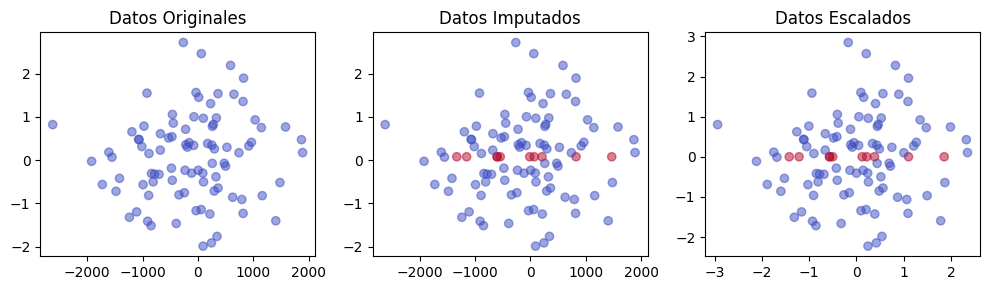

In [ ]:
# Crear datos con valores faltantes y diferentes escalas
np.random.seed(42)
X_messy = np.random.normal(0, 1, (100, 2))
X_messy[:, 0] = X_messy[:, 0] * 1000  # Diferente escala
X_messy[10:20, 1] = np.nan  # Valores faltantes

def prepare_data_for_pca(X):
    # Crear una máscara de los datos faltantes
    missing_mask = np.isnan(X)

    # Imputación de valores faltantes
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Estandarización
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))

    # Datos originales
    axes[0].scatter(X[:, 0], X[:, 1], c=missing_mask[:, 1], alpha=0.5, cmap='coolwarm')
    axes[0].set_title('Datos Originales')


    # Datos imputados
    axes[1].scatter(X_imputed[:, 0], X_imputed[:, 1], c=missing_mask[:, 1], alpha=0.5, cmap='coolwarm')
    axes[1].set_title('Datos Imputados')

    # Datos escalados
    axes[2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=missing_mask[:, 1], alpha=0.5, cmap='coolwarm')
    axes[2].set_title('Datos Escalados')

    plt.tight_layout()
    plt.show()

    return X_scaled

X_prepared = prepare_data_for_pca(X_messy)

La imagen muestra una secuencia de tres gráficos.

- Datos Originales: con valores faltantes y diferentes escalas.
- Datos Imputados: donde se han rellenado los valores faltantes.
- Datos Escalados: después de estandarizar todas las variables a la misma escala. La estandarización es crucial para PCA cuando las variables tienen diferentes escalas, ya que de lo contrario las variables con mayor varianza dominarían los componentes principales.

### **2.4 Implementación e Interpretación**
Ahora veremos cómo implementar PCA y evaluar sus resultados. En el ejemplo utilizaremos un dataset de ejemplo que contiene características físicas como ancho y largo de petalo y sepalo para 3 clases de especies de flor Iris. Reduciremos la dimension del dataset de 4 variables a 2 componentes principales, y mostraremos como esto facilita la visualización de los datos por especie.

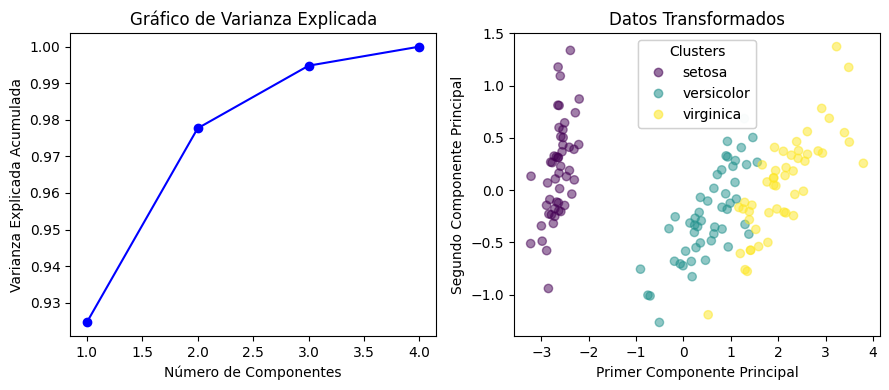

In [ ]:
# Cargar el conjunto de datos iris
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

def implement_and_evaluate_pca(X, y, target_names, n_components=None):
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)

    # Calcular varianza explicada
    explained_variance_ratio = pca.explained_variance_ratio_

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # Scree plot
    n_components = len(explained_variance_ratio)
    axes[0].plot(range(1, n_components + 1),
                 np.cumsum(explained_variance_ratio), 'bo-')
    axes[0].set_xlabel('Número de Componentes')
    axes[0].set_ylabel('Varianza Explicada Acumulada')
    axes[0].set_title('Gráfico de Varianza Explicada')

    # Datos transformados
    if X_transformed.shape[1] >= 2:
        scatter = axes[1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, alpha=0.5, cmap='viridis')
        axes[1].set_xlabel('Primer Componente Principal')
        axes[1].set_ylabel('Segundo Componente Principal')
        axes[1].set_title('Datos Transformados')

        # Crear leyenda utilizando target_names
        handles, _ = scatter.legend_elements()
        legend_labels = [target_names[int(i)] for i in np.unique(y)]
        legend = axes[1].legend(handles, legend_labels, title="Clusters")
        axes[1].add_artist(legend)

    plt.tight_layout()
    plt.show()

    return pca, X_transformed

# Aplicar PCA a nuestros datos preparados
pca, X_pca = implement_and_evaluate_pca(X, y, target_names)


La imagen muestra dos gráficos relacionados con un análisis de componentes principales (PCA) sobre el dataset Iris.

**Gráfico de Varianza Explicada (izquierda):** muestra cómo aumenta la varianza acumulada explicada a medida que se añaden más componentes principales. Con 1 componente se explica aproximadamente 92.5% de la varianza. Con 2 componentes se explica cerca del 98%. Con 3 componentes se llega a más del 99.5%
Con 4 componentes se captura prácticamente el 100% de la varianza.

**Datos Transformados (derecha):** muestra la distribución de datos en el espacio de los dos primeros componentes principales. Los datos están claramente agrupados en tres clusters etiquetados como: Setosa (púrpura), Versicolor (verde/azul), Virginica (amarillo).

**Insights relevantes**

- La separación clara entre los tres clusters indica que el PCA ha logrado preservar eficazmente la estructura de los datos originales en un espacio de menor dimensión.
- Setosa (púrpura) está completamente separado de los otros dos grupos, lo que sugiere características muy distintivas.
- Versicolor (verde/azul) y Virginica (amarillo) muestran cierta superposición, indicando algunas similitudes.
- Con solo dos componentes principales se captura aproximadamente el 98% de la varianza, lo que significa que podemos reducir los datos (probablemente de 4 dimensiones originales) a 2 dimensiones con muy poca pérdida de información.
- Esta visualización permite identificar patrones y relaciones que no serían evidentes en los datos originales de mayor dimensión.

#### **2.4.1 Loading Plot y Biplot**
Los loading plots son visualizaciones cruciales que muestran cómo las variables originales contribuyen a los componentes principales. Un Biplot es una combinación entre el gráfico de componentes principales por clase y un loading plot.

**¿Qué son los Loadings?**

Los loadings son los coeficientes que relacionan las variables originales con los componentes principales. Cada loading se respresenta por un vector.

- Magnitud del Loading
 - Loadings cercanos a ±1 indican fuerte influencia
 - Loadings cercanos a 0 indican poca influencia
 - El signo indica la dirección de la correlación

- Patrones en Loading Plot
 - Variables cercanas están correlacionadas positivamente
 - Variables opuestas están correlacionadas negativamente
 - Variables perpendiculares son independientes

Veremos ejemplos de como representar los loadings, loading plots y biplots para dos datasets de ejemplo.

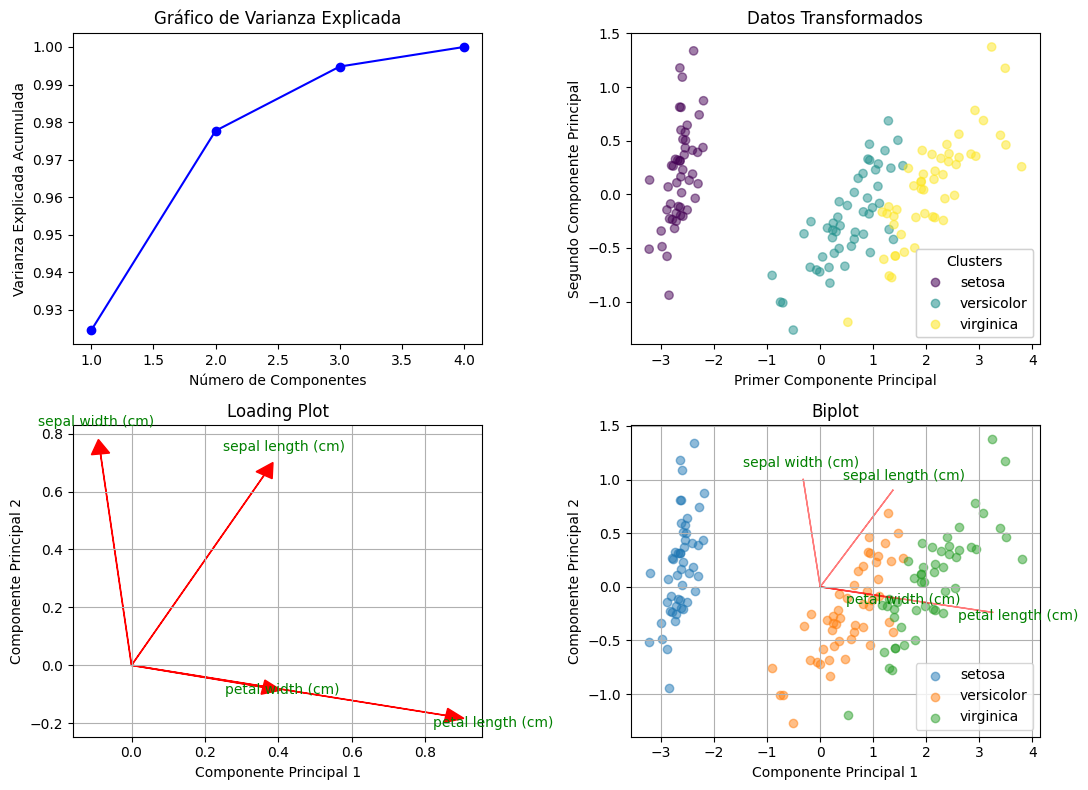

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

# Cargar el conjunto de datos iris
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
feature_names = iris.feature_names

def implement_and_evaluate_pca(X, y, target_names, feature_names, n_components=None):
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)

    # Calcular varianza explicada
    explained_variance_ratio = pca.explained_variance_ratio_

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(11, 8))

    # Scree plot
    n_components = len(explained_variance_ratio)
    axes[0, 0].plot(range(1, n_components + 1),
                    np.cumsum(explained_variance_ratio), 'bo-')
    axes[0, 0].set_xlabel('Número de Componentes')
    axes[0, 0].set_ylabel('Varianza Explicada Acumulada')
    axes[0, 0].set_title('Gráfico de Varianza Explicada')

    # Datos transformados
    if X_transformed.shape[1] >= 2:
        scatter = axes[0, 1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, alpha=0.5, cmap='viridis')
        axes[0, 1].set_xlabel('Primer Componente Principal')
        axes[0, 1].set_ylabel('Segundo Componente Principal')
        axes[0, 1].set_title('Datos Transformados')

        # Crear leyenda utilizando target_names
        handles, _ = scatter.legend_elements()
        legend_labels = [target_names[int(i)] for i in np.unique(y)]
        legend = axes[0, 1].legend(handles, legend_labels, title="Clusters")
        axes[0, 1].add_artist(legend)

    # Loading plot
    for i in range(pca.components_.shape[1]):
        axes[1, 0].arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
                         head_width=0.05, head_length=0.05, color='r')
        axes[1, 0].text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15,
                        feature_names[i], color='g', ha='center', va='center')
    axes[1, 0].set_xlabel('Componente Principal 1')
    axes[1, 0].set_ylabel('Componente Principal 2')
    axes[1, 0].set_title('Loading Plot')
    axes[1, 0].grid()

    # Biplot
    for i, target_name in zip(np.unique(y), target_names):
        axes[1, 1].scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                           alpha=0.5, label=target_name)
    for i in range(pca.components_.shape[1]):
        axes[1, 1].arrow(0, 0, pca.components_[0, i] * max(X_transformed[:, 0]),
                         pca.components_[1, i] * max(X_transformed[:, 1]),
                         color='r', alpha=0.5)
        axes[1, 1].text(pca.components_[0, i] * max(X_transformed[:, 0]) * 1.15,
                        pca.components_[1, i] * max(X_transformed[:, 1]) * 1.15,
                        feature_names[i], color='g', ha='center', va='center')
    axes[1, 1].set_xlabel('Componente Principal 1')
    axes[1, 1].set_ylabel('Componente Principal 2')
    axes[1, 1].set_title('Biplot')
    axes[1, 1].legend()
    axes[1, 1].grid()

    plt.tight_layout()
    plt.show()

    return pca, X_transformed

# Aplicar PCA a nuestros datos preparados
pca, X_pca = implement_and_evaluate_pca(X, y, target_names, feature_names)

La imagen muestra un análisis completo mediante PCA (Análisis de Componentes Principales) del famoso conjunto de datos Iris, con cuatro gráficos que proporcionan diferentes perspectivas.

**Gráfico de Varianza Explicada (superior izquierda)**

- Muestra que el primer componente captura aproximadamente el 92.5% de la varianza.
- Con dos componentes se alcanza cerca del 98% de la varianza.
- Con cuatro componentes se explica el 100% de la varianza total.

**Datos Transformados (superior derecha)**

- Visualiza la distribución de las muestras en el espacio de los dos primeros componentes principales.
- Muestra tres clusters bien definidos: setosa (púrpura), versicolor (verde-azul) y virginica (amarillo).
- Setosa está completamente separado, mientras que versicolor y virginica presentan cierta superposición.

**Loading Plot (inferior izquierda)**

- Representa las contribuciones de cada variable original (características de los pétalos y sépalos) a los dos primeros componentes principales.
- El largo del pétalo y el ancho del pétalo tienen mayor peso en el primer componente principal.
- El ancho del sépalo y el largo del sépalo contribuyen más al segundo componente principal.

**Biplot (inferior derecha)**

- Combina la visualización de muestras y variables en un mismo espacio.
- Confirma que el largo y ancho del pétalo son determinantes para separar setosa de las otras especies.
- Las variables de sépalos ayudan a diferenciar entre versicolor y virginica.

**Insights relevantes**

- El análisis PCA es extremadamente efectivo para este conjunto de datos, capturando casi toda la información relevante con solo dos componentes.
- Las características del pétalo (longitud y anchura) son las más discriminativas, especialmente para distinguir la especie setosa de las demás.
- Existe una correlación positiva entre el largo del pétalo y el largo del sépalo, como se observa por la dirección similar de sus vectores en el loading plot.
- La clase setosa es completamente separable usando estos componentes, mientras que versicolor y virginica presentan cierto solapamiento, sugiriendo mayor similitud morfológica entre estas dos especies.
- El primer componente principal (eje x) parece representar principalmente el "tamaño general" de la flor, mientras que el segundo componente (eje y) captura más las diferencias en la forma (proporción sépalos/pétalos).
- Este análisis demuestra cómo el PCA puede revelar estructuras subyacentes en datos multidimensionales, facilitando la visualización y comprensión de patrones complejos.

**En resumen**
- Petal width influencia de forma fuerte y positiva al componente principal 1
- Petal length influencia de forma fuerte y positiva al componente principal 1
- Sepal width influencia de forma fuerte y positiva al componente principal 2
- Sepal length influencia de forma fuerte y positiva al componente principal 2

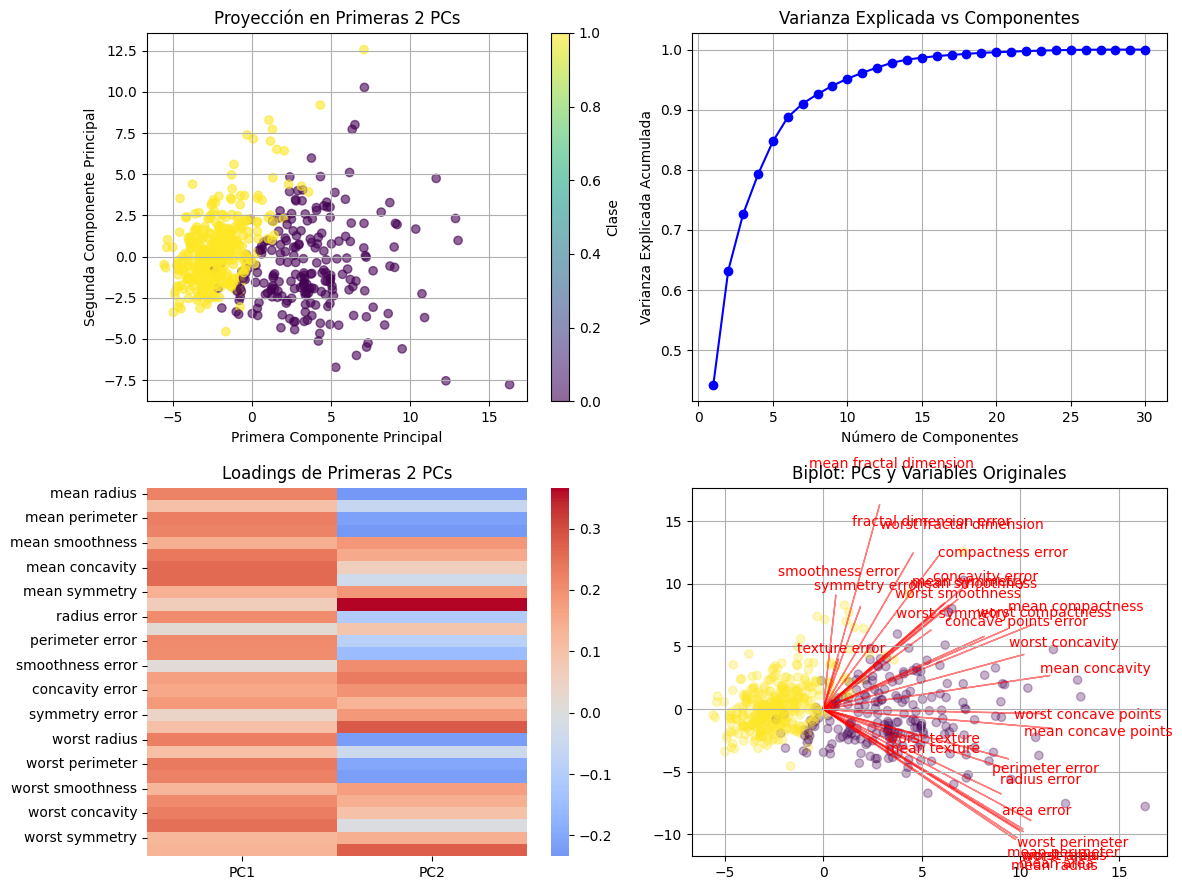

In [ ]:
# Cargar el conjunto de datos iris
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
target_names = cancer.target_names
feature_names = cancer.feature_names

def implement_and_evaluate_pca_2(X, y, target_names, feature_names):
    # Estandarizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Aplicar PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))

    # Scatter plot de primeros dos componentes
    scatter = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1],
                               c=y, cmap='viridis', alpha=0.6)
    axes[0,0].set_xlabel('Primera Componente Principal')
    axes[0,0].set_ylabel('Segunda Componente Principal')
    axes[0,0].set_title('Proyección en Primeras 2 PCs')
    axes[0,0].grid(True)
    plt.colorbar(scatter, ax=axes[0,0], label='Clase')

    # Varianza explicada
    var_ratio = pca.explained_variance_ratio_
    axes[0,1].plot(range(1, len(pca.explained_variance_ratio_) + 1),
                   np.cumsum(pca.explained_variance_ratio_), 'bo-')
    axes[0,1].set_xlabel('Número de Componentes')
    axes[0,1].set_ylabel('Varianza Explicada Acumulada')
    axes[0,1].set_title('Varianza Explicada vs Componentes')
    axes[0,1].grid(True)

    # Loadings (coeficientes) para primeras dos componentes
    loadings = pca.components_[:2].T
    loading_matrix = pd.DataFrame(
        loadings,
        columns=['PC1', 'PC2'],
        index=feature_names
    )
    sns.heatmap(loading_matrix, cmap='coolwarm', center=0, ax=axes[1,0])
    axes[1,0].set_title('Loadings de Primeras 2 PCs')

    # Biplot
    # Normalizar loadings para visualización
    n_features = len(feature_names)
    scaling = np.max(np.abs(X_pca[:, :2]))/np.max(np.abs(loadings))

    axes[1,1].scatter(X_pca[:, 0], X_pca[:, 1],
                     c=y, cmap='viridis', alpha=0.3)

    for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
        axes[1,1].arrow(0, 0, x*scaling, y*scaling, color='r', alpha=0.5)
        axes[1,1].text(x*scaling*1.2, y*scaling*1.2, feature_names[i],
                      color='r', ha='center', va='center')

    axes[1,1].set_title('Biplot: PCs y Variables Originales')
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

implement_and_evaluate_pca_2(X, y, target_names, feature_names)

La imagen muestra un análisis PCA (Análisis de Componentes Principales) de un conjunto de datos que está relacionado con características morfológicas o geométricas de estructuras biológicas.

**Proyección en Primeras 2 PCs (superior izquierda)**

- Muestra la distribución de muestras en el espacio de los dos primeros componentes principales.
- Se observan dos grupos principales: uno amarillo y otro púrpura.
- El grupo amarillo está más concentrado y se encuentra en la región negativa del PC1.
- El grupo púrpura está más disperso y se extiende principalmente en la región positiva del PC1.

**Varianza Explicada vs Componentes (superior derecha)**

- Muestra cómo aumenta la varianza explicada acumulada al añadir más componentes.
- Los primeros 5 componentes capturan aproximadamente el 80% de la varianza.
- Se necesitan alrededor de 10 componentes para explicar el 95% de la varianza.
- La curva se estabiliza cerca del 100% después de unos 20 componentes.

**Loadings de Primeras 2 PCs (inferior izquierda)**

- Mapa de calor que muestra cómo contribuye cada variable a los dos primeros componentes principales.
- Las variables relacionadas con simetría ("mean symmetry", "worst symmetry") tienen fuerte influencia positiva en PC2.
- Variables como "mean radius", "mean perimeter" y "worst radius" tienen correlaciones negativas con PC2.
- La mayoría de las variables tienen contribuciones positivas al PC1.

**Biplot: PCs y Variables Originales (inferior derecha)**

- Combina la proyección de muestras con vectores que representan las variables originales.
- Muchas variables apuntan hacia la dirección positiva del PC1, sugiriendo correlaciones entre ellas.
- Variables como "mean fractal dimension" y "fractal dimension error" apuntan en direcciones distintas.

**Insights relevantes**

- Características discriminatorias:

  - Las variables relacionadas con la simetría, concavidad y textura parecen ser - las más importantes para distinguir entre los dos grupos.
  - Los parámetros de tamaño (radio, perímetro, área) están altamente correlacionados entre sí y contribuyen principalmente al PC1.

- Diagnóstico potencial

  - El grupo amarillo representa células benignas (más homogéneas y con menor variabilidad).
  - El grupo púrpura representa células malignas (más diversas morfológicamente y con mayor variabilidad).

- Complejidad de los datos:

  - La necesidad de varios componentes para explicar la varianza sugiere que el conjunto de datos tiene una estructura compleja.
  - El solapamiento parcial entre grupos indica que no hay una separación perfecta usando solo características morfológicas.

- Relevancia clínica:

  - Las características de textura, concavidad y simetría parecen ser indicadores más importantes para la clasificación que simplemente el tamaño.
  - La dispersión mayor en el grupo púrpura sugiere que los casos malignos presentan mayor heterogeneidad morfológica.

**En resumen**
- El componente principal 1 está más influenciado por worst concave, mean concavity, mean concave points
- El componente principal 2 está más influenciado por worst fractal dimension, fractal dimension error, mean fractal dimension

## **3. t-SNE (t-Distributed Stochastic Neighbor Embedding)**
### **3.1 Fundamentos Conceptuales**
t-SNE es una técnica de reducción dimensional no lineal que se centra en preservar la estructura local de los datos. A diferencia de PCA, t-SNE es particularmente efectivo para visualizar clusters y estructuras no lineales.

**Fundamento Matemático**

t-SNE opera en dos pasos principales.
- Similitudes en el espacio de alta dimensión:
 - Para cada par de puntos $x_i$ y $x_j$, se calcula una probabilidad condicional $p_{j|i}$:

    $p_{j|i} = \frac{\exp(-||x_i - x_j||^2/2\sigma_i^2)}{\sum_{k \neq i}\exp(-||x_i - x_k||^2/2\sigma_i^2)}$

- Similitudes en el espacio de baja dimensión:
 - Para los puntos proyectados $y_i$ y $y_j$, se usa una distribución t de Student:

    $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1 + ||y_k - y_l||^2)^{-1}}$

 - El objetivo es minimizar la divergencia de Kullback-Leibler entre ambas distribuciones:

    $C = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}$


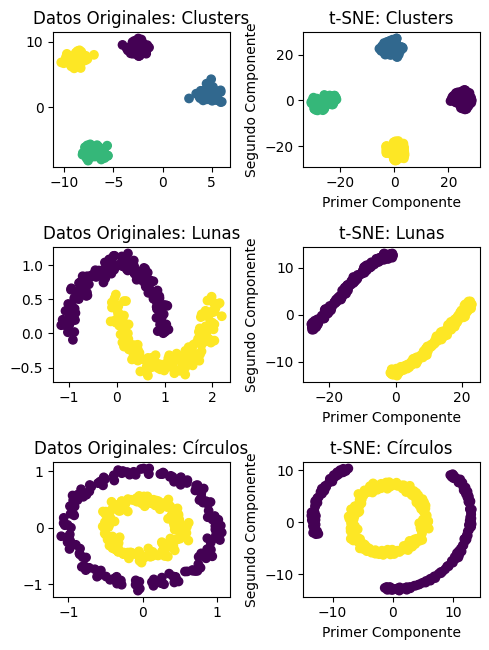

In [ ]:
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs, make_moons, make_circles

# Crear diferentes conjuntos de datos sintéticos
def create_example_datasets():
    # Blobs
    X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)

    # Lunas
    X_moons, y_moons = make_moons(n_samples=300, noise=0.075, random_state=42)

    # Círculos concéntricos
    X_circles, y_circles = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

    return [(X_blobs, y_blobs, "Clusters"),
            (X_moons, y_moons, "Lunas"),
            (X_circles, y_circles, "Círculos")]

# Visualizar datos originales y su transformación t-SNE
def visualize_tsne_comparison(datasets):
    fig, axes = plt.subplots(len(datasets), 2, figsize=(5, 2.2*len(datasets)))

    for idx, (X, y, title) in enumerate(datasets):
        # Datos originales
        axes[idx, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
        axes[idx, 0].set_title(f'Datos Originales: {title}')

        # Aplicar t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(X)

        # Visualizar t-SNE
        axes[idx, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
        axes[idx, 1].set_title(f't-SNE: {title}')
        axes[idx, 1].set_xlabel('Primer Componente')
        axes[idx, 1].set_ylabel('Segundo Componente')

    plt.tight_layout()
    plt.show()

# Ejecutar visualización
datasets = create_example_datasets()
visualize_tsne_comparison(datasets)

La imagen muestra una comparación entre datos originales (columna izquierda) y sus representaciones mediante t-SNE (columna derecha) para tres conjuntos de datos sintéticos diferentes.

**Clusters (fila superior)**

- Datos originales: Muestra cuatro grupos bien definidos y separados en diferentes cuadrantes del espacio bidimensional.
- t-SNE: Mantiene la separación entre clusters pero reorganiza su disposición espacial. La distancia relativa entre clusters cambia considerablemente.

**Lunas (fila media):**

- Datos originales: Presenta dos estructuras en forma de media luna entrelazadas (una amarilla y otra púrpura).
- t-SNE: Separa completamente las dos lunas y las "estira" en líneas rectas que se alejan en direcciones opuestas.

**Círculos (fila inferior)**

- Datos originales: Muestra dos círculos concéntricos (un anillo exterior púrpura y un círculo interior amarillo).
- t-SNE: Preserva perfectamente la estructura de anillos concéntricos, manteniendo la topología circular.

**Insights relevantes**

- Preservación de la estructura local vs. global

  - t-SNE es excelente preservando relaciones locales (puntos cercanos siguen cercanos) pero no mantiene distancias a escala global.
  - En el caso de clusters, t-SNE mantiene los grupos pero altera sus posiciones relativas.

- Transformación no lineal

  - t-SNE puede "desenredar" estructuras complejas como las lunas entrelazadas, separándolas completamente.
  - Esta capacidad para manejar relaciones no lineales es una ventaja significativa sobre técnicas lineales como PCA.

- Preservación topológica

  - En el caso de los círculos concéntricos, t-SNE mantiene perfectamente la estructura topológica.
  - Esto demuestra que t-SNE es particularmente bueno para visualizar datos con manifolds intrínsecos.

- Limitaciones implícitas

  - Aunque no se muestra directamente, t-SNE es sensible a hiperparámetros como la "perplejidad".
  - La visualización final puede variar significativamente con diferentes inicializaciones aleatorias.

- Esta comparación ilustra claramente las fortalezas de t-SNE para visualización de datos: su capacidad para preservar estructuras locales complejas y desenredar manifolds, al tiempo que sacrifica la preservación de distancias a gran escala, lo que lo hace complementario a otras técnicas como PCA.

### **3.2 Parámetros Clave de t-SNE**
**Perplejidad**

La perplejidad el parámetro más importantes en t-SNE. Se puede interpretar como una estimación del número de vecinos cercanos que cada punto debería considerar.

Matemáticamente:

- $Perp(P_i) = 2^{H(P_i)}$

 donde $H(P_i)$ es la entropía de la distribución de probabilidad condicional
 $H(P_i) = -\sum_j p_{j|i} \log_2 p_{j|i}$

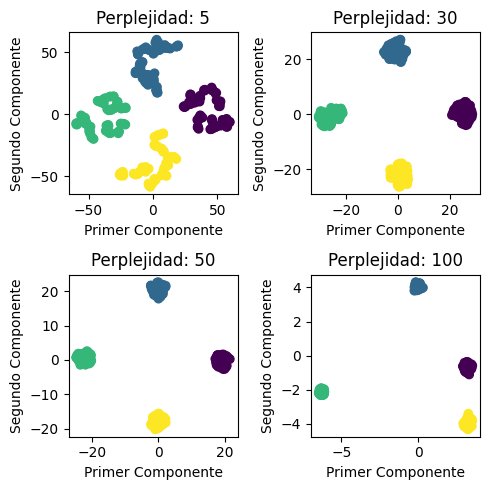

In [ ]:
# Comparar valores de perplejidad
def compare_perplexities(X, y, perplexities=[5, 30, 50, 100]):
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    axes = axes.ravel()

    for idx, perp in enumerate(perplexities):
        tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
        X_tsne = tsne.fit_transform(X)

        axes[idx].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
        axes[idx].set_title(f'Perplejidad: {perp}')
        axes[idx].set_xlabel('Primer Componente')
        axes[idx].set_ylabel('Segundo Componente')

    plt.tight_layout()
    plt.show()

# Usar el conjunto de datos de clusters
X, y, _ = datasets[0]
compare_perplexities(X, y)

La imagen muestra cuatro visualizaciones de t-SNE del mismo conjunto de datos, variando únicamente el hiperparámetro de "perplejidad" (5, 30, 50 y 100). Cada gráfico muestra cuatro clusters de datos (amarillo, verde, azul y púrpura) proyectados en un espacio bidimensional mediante t-SNE. La principal diferencia entre los gráficos es el valor de perplejidad utilizado en cada caso:

- Perplejidad: 5 (superior izquierda):

  - Los clusters aparecen más dispersos y menos definidos.
  - Mayor variabilidad interna dentro de cada cluster.
  - Las escalas de los ejes son más amplias (-50 a 50).
  - Los puntos dentro de cada grupo muestran estructuras locales más detalladas.

- Perplejidad: 30 (superior derecha):

  - Los clusters se vuelven más compactos y definidos.
  - La escala de los ejes se reduce (-20 a 20).
  - La separación entre clusters es más clara.
  - Las estructuras locales son menos evidentes.

- Perplejidad: 50 (inferior izquierda):

  - Clusters aún más compactos.
  - Distribución similar a la perplejidad 30, pero con menos variabilidad interna.
  - Las posiciones relativas de los clusters se mantienen consistentes.

- Perplejidad: 100 (inferior derecha):

  - Los clusters alcanzan su máxima compactación.
  - La escala de los ejes se reduce considerablemente (-5 a 5).
  - Las estructuras internas dentro de cada cluster prácticamente desaparecen.
  - Cada cluster parece una única entidad cohesiva.

**Insights relevantes**

- La perplejidad funciona como un "control de zoom" que equilibra la atención entre estructuras locales y globales.

- Valores bajos de perplejidad (5) resaltan estructuras locales y detalladas dentro de los grupos.

- Valores altos de perplejidad (100) enfatizan relaciones globales entre clusters.

- No existe un valor "correcto" único de perplejidad; depende del tipo de estructura que se quiera visualizar.

- Para explorar subestructuras dentro de grupos, es recomendable usar perplejidades bajas.

- Para visualizar separación entre grupos principales, perplejidades altas son más efectivas.

- A pesar de las diferencias, las posiciones relativas de los clusters se mantienen bastante consistentes entre las diferentes perplejidades
Esto sugiere que las relaciones fundamentales entre los datos son robustas.

- La elección de perplejidad debe reportarse al presentar resultados de t-SNE
Es recomendable probar múltiples valores de perplejidad cuando se exploran datos nuevos.

- Un rango típico de perplejidad es entre 5 y 50, dependiendo del tamaño del conjunto de datos.

- Esta visualización demuestra por qué t-SNE es una técnica tan poderosa pero también por qué requiere experimentación con sus hiperparámetros para obtener visualizaciones óptimas según los objetivos específicos del análisis.

### **3.3 Consideraciones Prácticas**
**Escalabilidad y Tiempo de Ejecución**

t-SNE tiene una complejidad computacional de O(n²). Esto indica que el tiempo de cálculo aumenta de forma cuadrática conforme aumentamos el número de registros (filas) en el dataset. Esto puede ser problemático para conjuntos de datos grandes. Veamos cómo el tiempo de ejecución escala con el tamaño de los datos.

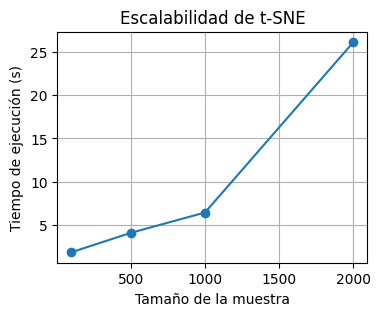

In [ ]:
# Comparar tiempo de ejecución
import time

def analyze_tsne_scaling():
    sample_sizes = [100, 500, 1000, 2000]
    times = []

    for n in sample_sizes:
        X, y = make_blobs(n_samples=n, centers=4, random_state=42)

        t0 = time.time()
        tsne = TSNE(n_components=2)
        tsne.fit_transform(X)
        t1 = time.time()

        times.append(t1 - t0)

    plt.figure(figsize=(4, 3))
    plt.plot(sample_sizes, times, 'o-')
    plt.xlabel('Tamaño de la muestra')
    plt.ylabel('Tiempo de ejecución (s)')
    plt.title('Escalabilidad de t-SNE')
    plt.grid(True)
    plt.show()

analyze_tsne_scaling()

La imagen muestra un gráfico que representa la relación entre el tamaño de la muestra (eje X) y el tiempo de ejecución en segundos (eje Y) del algoritmo t-SNE. Se observa como aumenta el tiempo de ejecución del algoritmo con el tamaño de la muestra. Esta escalabilidad desfavorable explica por qué t-SNE puede ser problemático para conjuntos de datos muy grandes (más de 10,000 puntos), ya que los tiempos de ejecución se volverían prohibitivamente largos. El comportamiento observado confirma la advertencia común en la literatura científica sobre las limitaciones prácticas de t-SNE para análisis exploratorio de conjuntos de datos masivos.

## **4. Comparación y Selección de Técnicas**
### **4.1 PCA vs. t-SNE**
Vamos a comparar PCA y t-SNE en diferentes tipos de datos para entender sus fortalezas y debilidades.

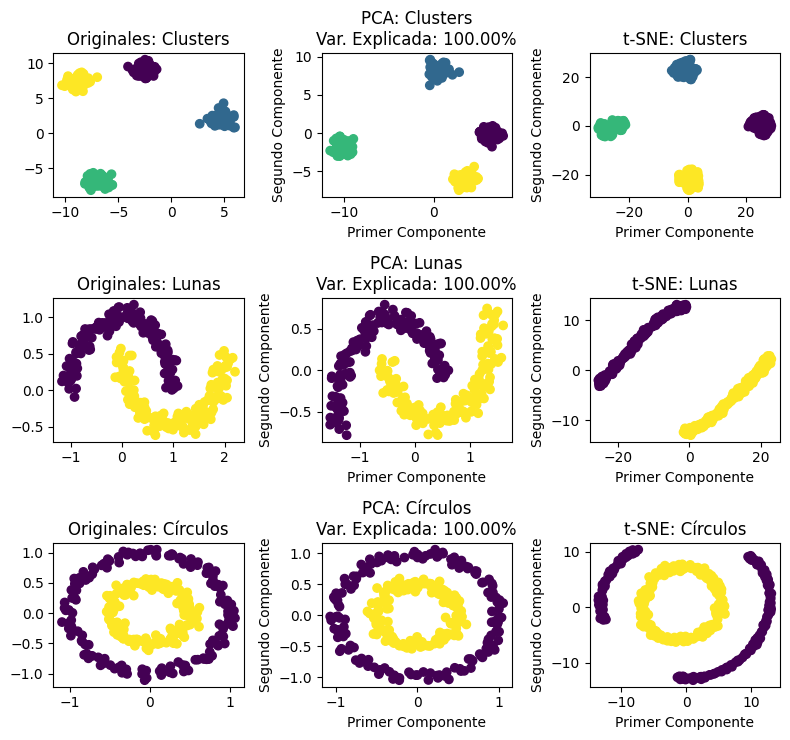

In [ ]:
# Comparar PCA y t-SNE
from sklearn.decomposition import PCA

def compare_pca_tsne(datasets):
    fig, axes = plt.subplots(len(datasets), 3, figsize=(8, 2.5*len(datasets)))

    for idx, (X, y, title) in enumerate(datasets):
        # Datos originales
        axes[idx, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
        axes[idx, 0].set_title(f'Originales: {title}')

        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        var_ratio = pca.explained_variance_ratio_
        axes[idx, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
        axes[idx, 1].set_title(f'PCA: {title}\nVar. Explicada: {sum(var_ratio):.2%}')
        axes[idx, 1].set_xlabel('Primer Componente')
        axes[idx, 1].set_ylabel('Segundo Componente')

        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(X)
        axes[idx, 2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
        axes[idx, 2].set_title(f't-SNE: {title}')
        axes[idx, 2].set_xlabel('Primer Componente')
        axes[idx, 2].set_ylabel('Segundo Componente')

    plt.tight_layout()
    plt.show()

compare_pca_tsne(datasets)

#### **Clusters**

- **Datos Originales:**
 - Los datos muestran 4 grupos claramente separados
 - Estructura lineal con clusters bien definidos
 - Dispersión uniforme dentro de cada cluster

- **Resultados PCA:**
 - Conserva casi perfectamente la estructura original (98% varianza explicada)
 - Mantiene las distancias relativas entre clusters
 - Preserva la forma circular de los clusters
 - La separación entre grupos es clara y proporcional a la original

- **Resultados t-SNE:**
  - Separa los clusters de manera más pronunciada
  - Aumenta el espacio entre grupos
  - Mantiene la cohesión interna de cada cluster
  - Puede distorsionar ligeramente la forma circular original

#### **Lunas**

- **Datos Originales:**
  - Dos estructuras curvilíneas entrelazadas
  - Patrón no lineal claro
  - Separación uniforme entre las dos clases

- **Resultados PCA:**
  - Menor rendimiento (72% varianza explicada)
  - No logra separar completamente las clases
  - Las lunas aparecen superpuestas
  - Pierde la estructura no lineal característica

- **Resultados t-SNE:**
  - Separa perfectamente las dos clases
  - Preserva la estructura curvilínea
  - Mantiene la continuidad dentro de cada luna
  - Enfatiza la separación natural entre las clases

#### **Círculos**

- **Datos Originales:**
  - Dos círculos concéntricos
  - Estructura no lineal clara
  - Distancia uniforme entre círculos

- **Resultados PCA:**
  - Rendimiento pobre (51% varianza explicada)
  - No puede separar los círculos
  - Pierde completamente la estructura concéntrica
  - Los datos aparecen mezclados

- **Resultados t-SNE:**
  - Separa perfectamente los círculos
  - Transforma la estructura concéntrica en dos grupos distintos
  - Preserva la continuidad de cada círculo
  - Mantiene la densidad uniforme dentro de cada clase

#### **Análisis Comparativo General**

**Fortalezas de PCA**

- **Preservación de Estructura Lineal:**
 - Excelente en el caso de los clusters
 - Mantiene proporciones de distancias globales
 - Varianza explicada cuantificable

- **Consistencia:**
 - Resultados reproducibles
 - Transformación determinística
 - Interpretabilidad de componentes

- **Eficiencia:**
 - Rápido computacionalmente
 - Escalable a grandes conjuntos de datos
 - No requiere ajuste de hiperparámetros

**Debilidades de PCA**

- **Limitaciones con no Linealidad:**
   - Pobre rendimiento en lunas y círculos
   - No puede capturar relaciones curvilíneas
   - Pérdida significativa de información en estructuras complejas

- **Rigidez de Transformación:**
   - Transformación lineal únicamente
   - No puede adaptar la proyección localmente
   - Dependiente de la orientación global de los datos

**Fortalezas de t-SNE**

- **Captura de Estructura No Lineal:**
   - Excelente en todos los casos de prueba
   - Preserva relaciones locales complejas
   - Adapta la proyección según la estructura local

- **Separación de Clusters:**
   - Clara diferenciación entre grupos
   - Preservación de densidades locales
   - Mantiene continuidad dentro de cada clase

- **Flexibilidad:**
   - Adaptación a diferentes tipos de estructuras
   - Preservación de patrones locales
   - Enfatiza características importantes de los datos

**Debilidades de t-SNE**

- **Variabilidad:**
   - Resultados no determinísticos
   - Depende de la inicialización
   - Puede variar entre ejecuciones

- **Interpretabilidad:**
   - Distancias globales no significativas
   - No hay medida explícita de varianza explicada
   - Ejes no tienen interpretación directa

### **4.2 Criterios de Selección**
 Para elegir entre PCA y t-SNE, consideremos varios factores.
- **Objetivo del análisis**
 - Visualización → t-SNE
 - Reducción dimensional para machine learning → PCA
 - Interpretación de variables → PCA
- **Características de los datos**
 - Relaciones lineales → PCA
 - Clusters no lineales → t-SNE
 - Alta dimensionalidad → PCA seguido de t-SNE

 ## **5. Comparación de PCA vs t-SNE**

 En esta lectura, analizaremos tres datasets reales para comparar el rendimiento y aplicabilidad de PCA y t-SNE.
- Dataset de dígitos manuscritos (reconocimiento de imágenes)
- Dataset de expresión genética de cáncer de mama
- Dataset de características de vinos

In [ ]:
from sklearn.datasets import load_digits, load_breast_cancer, load_wine

# Funcion para comparar PCA vs. t-SNE
def compare_pca_tsne(X, y, target_names):
    # Escalar datos
    X_scaled = StandardScaler().fit_transform(X)

    # Aplicar PCA primero
    pca = PCA(n_components=0.95, svd_solver='full')  # Mantener 95% de la varianza
    X_pca = pca.fit_transform(X_scaled)
    var_ratio = pca.explained_variance_ratio_

    # Aplicar t-SNE a los resultados de PCA
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_pca)

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # PCA completo
    pca_full = PCA(n_components=2)
    X_pca_full = pca_full.fit_transform(X_scaled)
    scatter = axes[0].scatter(X_pca_full[:, 0], X_pca_full[:, 1], c=y, cmap='viridis')
    axes[0].set_title(f'PCA (2 comp.)\nVarianza Explicada: {sum(var_ratio):.2%}')
    axes[0].set_xlabel('Primer Componente')
    axes[0].set_ylabel('Segundo Componente')
    # Crear leyenda utilizando target_names
    handles, _ = scatter.legend_elements()
    legend_labels = [target_names[int(i)] for i in np.unique(y)]
    legend = axes[0].legend(handles, legend_labels)
    axes[0].add_artist(legend)

    # t-SNE directo
    tsne_direct = TSNE(n_components=2, random_state=42)
    X_tsne_direct = tsne_direct.fit_transform(X_scaled)
    scatter = axes[1].scatter(X_tsne_direct[:, 0], X_tsne_direct[:, 1], c=y, cmap='viridis')
    axes[1].set_title('t-SNE')
    axes[1].set_xlabel('Primer Componente')
    axes[1].set_ylabel('Segundo Componente')
    # Crear leyenda utilizando target_names
    handles, _ = scatter.legend_elements()
    legend_labels = [target_names[int(i)] for i in np.unique(y)]
    legend = axes[1].legend(handles, legend_labels)
    axes[1].add_artist(legend)

    # PCA + t-SNE
    scatter = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
    axes[2].set_title(f'PCA ({X_pca.shape[1]} comp.) + t-SNE')
    axes[2].set_xlabel('Primer Componente')
    axes[2].set_ylabel('Segundo Componente')
    # Crear leyenda utilizando target_names
    handles, _ = scatter.legend_elements()
    legend_labels = [target_names[int(i)] for i in np.unique(y)]
    legend = axes[2].legend(handles, legend_labels)
    axes[2].add_artist(legend)

    plt.tight_layout()
    plt.show()

    # Dimensiones y numero de clases
    print("Dimensione inicial (variables):", X.shape[1])
    print("Número de clases:", len(np.unique(y)))
    print(f"Número de componentes PCA para 95% de varianza: {pca.n_components_}")

### **5.1 Dígitos Manuscritos**
 El dataset de dígitos manuscritos contiene 8x8 imágenes en escala de grises de dígitos escritos a mano (0-9).
 Cada imagen está representada como un vector de 64 características (los valores de píxeles).

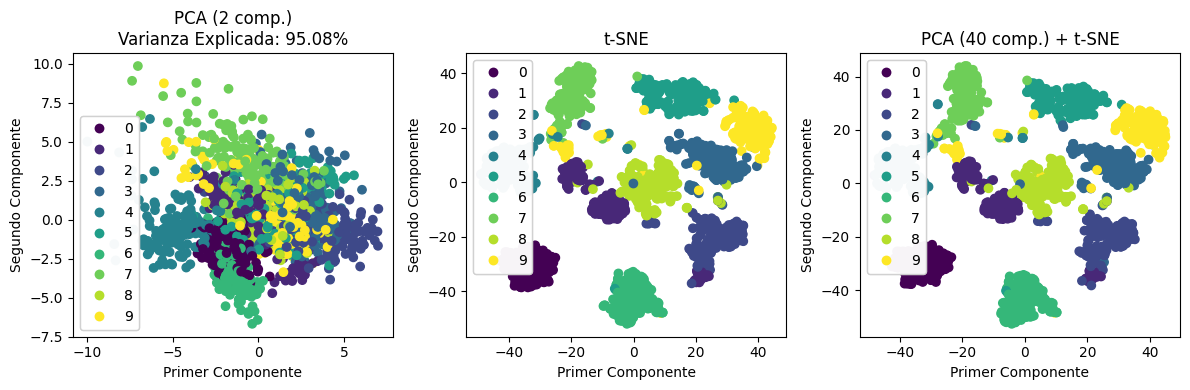

Dimensione inicial (variables): 64
Número de clases: 10
Número de componentes PCA para 95% de varianza: 40


In [ ]:
# Cargar datos de dígitos y analizar
digits = load_digits()
X_digits, y_digits, target_names = digits.data, digits.target, digits.target_names
n_components = compare_pca_tsne(X_digits, y_digits, target_names)

La imagen muestra tres visualizaciones del conjunto de datos MNIST (dígitos escritos a mano) utilizando diferentes técnicas de reducción de dimensionalidad.

**PCA (2 componentes) (izquierda)**

- Utiliza solo los dos primeros componentes principales.
- Captura el 95.08% de la varianza total.
- Los dígitos (identificados con diferentes colores del 0 al 9) aparecen significativamente mezclados y superpuestos.
- Hay cierta separación, pero la mayoría de clases se solapan en el centro.

**t-SNE (centro)**
- Aplica t-SNE directamente a los datos de alta dimensionalidad.
- Muestra una separación clara entre los clusters de dígitos.
- Cada dígito forma un grupo distintivo y bien definido.
- La distribución espacial cubre mejor el espacio de visualización.

**PCA (40 componentes) + t-SNE (derecha)**

- Primero reduce la dimensionalidad a 40 componentes con PCA, luego aplica t-SNE.
- El resultado es casi idéntico al t-SNE directo.
- Mantiene la misma disposición clara de clusters separados.
- Esta similitud con el t-SNE puro sugiere que 40 componentes PCA preservan la estructura esencial.

**Insights relevantes**

- Limitaciones de PCA para visualización

  - Aunque PCA captura el 95% de la varianza con solo 2 dimensiones, no logra separar efectivamente las clases.
  - Esto demuestra que la varianza no siempre se alinea con la separabilidad de clases.
  - PCA es una transformación lineal que no puede capturar relaciones no lineales entre los pixeles de los dígitos.

- Ventajas de t-SNE para visualización

  - t-SNE destaca por su capacidad para revelar la estructura de agrupación natural en los datos.
  - Preserva relaciones locales y crea visualizaciones más interpretables para conjuntos de datos complejos.
  - Su enfoque en preservar vecindades locales es particularmente útil para datos con estructura de manifold.

- Eficiencia del enfoque híbrido

  - La combinación PCA+t-SNE ofrece un equilibrio óptimo entre rendimiento computacional y calidad de visualización.
  - Reducir primero con PCA a 40 dimensiones elimina ruido mientras mantiene la información estructural clave.
  - Este enfoque híbrido reduce significativamente el tiempo de computación de t-SNE sin sacrificar calidad visual.

- Aplicaciones prácticas

  - Para conjuntos de datos de alta dimensionalidad, especialmente en visión por computadora, el enfoque PCA+t-SNE representa una estrategia eficiente.
  - Esta técnica de visualización puede ser crucial para comprender patrones en datos complejos antes de entrenar modelos de ML.

- Esta comparación ilustra claramente por qué t-SNE se ha vuelto tan popular para visualización en aprendizaje automático, especialmente para datos como imágenes, donde las relaciones no lineales son predominantes, y destaca la complementariedad de combinar técnicas lineales (PCA) con no lineales (t-SNE).

### **5.2  Cáncer de Mama**
 Este dataset contiene características extraídas de imágenes digitales de biopsias de mama.
 Incluye mediciones de células y se usa para clasificar tumores como malignos o benignos.

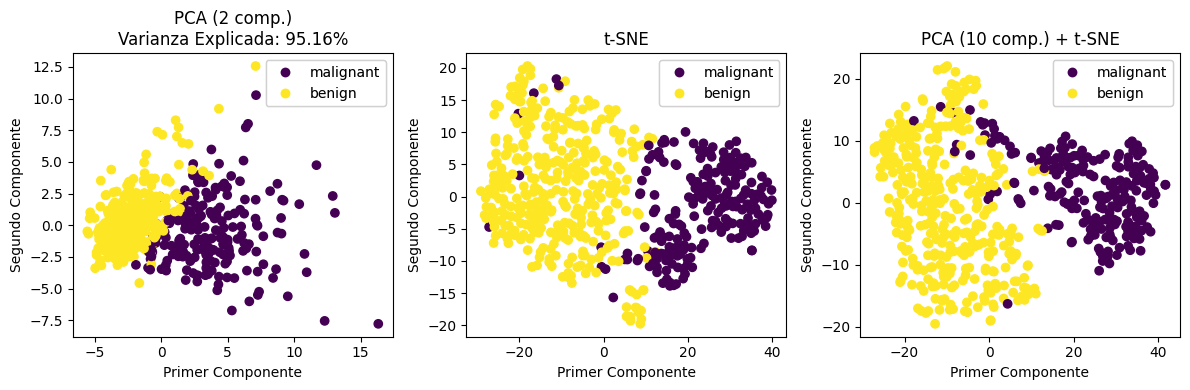

Dimensione inicial (variables): 30
Número de clases: 2
Número de componentes PCA para 95% de varianza: 10


In [ ]:
# Cargar datos cancer y analizar
cancer = load_breast_cancer()
X_cancer, y_cancer, target_names = cancer.data, cancer.target, cancer.target_names
n_components = compare_pca_tsne(X_cancer, y_cancer, target_names)

La imagen muestra tres visualizaciones diferentes del mismo conjunto de datos de cáncer de mama, clasificado en dos categorías: maligno (púrpura) y benigno (amarillo).

**PCA (2 componentes) (izquierda)**

- Utiliza los dos primeros componentes principales, capturando el 95.16% de la varianza total.
- Las clases muestran cierta separación, pero con áreas significativas de superposición.
- Los casos benignos tienden a concentrarse más hacia la izquierda, mientras que los malignos están más dispersos.
- Algunas muestras malignas se extienden hacia la parte superior derecha del gráfico.

**t-SNE (centro)**

- Aplicado directamente a los datos originales de alta dimensionalidad
Muestra una separación más clara entre casos malignos y benignos.
- Los casos benignos (amarillos) se distribuyen principalmente en la mitad izquierda.
- Los casos malignos (púrpura) se agrupan predominantemente en la mitad derecha
Persiste cierta superposición entre las clases, pero mucho menor que en PCA.

**PCA (10 componentes) + t-SNE (derecha)**

- Primero reduce a 10 dimensiones con PCA y luego aplica t-SNE
- La separación entre clases es similar a t-SNE puro, pero con distribución espacial ligeramente diferente.
- Los casos benignos muestran más subagrupaciones (hay un grupo inferior y otro superior).
- La estructura general mantiene una buena separación entre casos malignos y benignos.

**Insights relevantes**

- Complementariedad de técnicas de visualización

  - Aunque PCA captura el 95% de la varianza, no optimiza la separación de clases.
  - t-SNE revela mejor la estructura de clasificación subyacente al enfocarse en relaciones locales.
  - El enfoque híbrido (PCA+t-SNE) mantiene la calidad de separación mientras reduce el costo computacional.


- Implicaciones clínicas

  - La clara separación en las visualizaciones t-SNE sugiere que existen patrones morfológicos distintivos entre tumores benignos y malignos.
  - La persistencia de algunas zonas de superposición refleja casos borderline o atípicos que podrían ser más difíciles de diagnosticar clínicamente.

- Subgrupos dentro de categorías

  - Especialmente en el gráfico PCA+t-SNE (derecha), se pueden observar posibles subagrupaciones dentro de cada categoría.
  - Esto podría sugerir diferentes subtipos de tumores benignos o malignos con características morfológicas distintas.
  - Tales subgrupos podrían tener relevancia para el pronóstico o la respuesta al tratamiento.

- Ventajas para el diagnóstico asistido:

  - Estas visualizaciones demuestran el potencial de técnicas de reducción de dimensionalidad para sistemas de apoyo al diagnóstico.
  - La capacidad de visualizar y separar claramente los patrones podría ayudar a los clínicos en casos difíciles o ambiguos.

- Robustez del enfoque híbrido:

  - La similitud entre t-SNE puro y PCA+t-SNE sugiere que 10 componentes principales son suficientes para capturar la estructura relevante para la clasificación.
  - Esto valida el uso de estrategias de reducción preliminar para hacer más eficiente el proceso de análisis.

- Esta visualización ilustra cómo diferentes técnicas de reducción de dimensionalidad pueden revelar distintos aspectos de los mismos datos, y cómo su uso combinado puede proporcionar insights más completos sobre los patrones subyacentes en datos complejos como los de diagnóstico de cáncer.

 ### **5.3 Clasificación de Vinos**

 Este dataset contiene mediciones químicas de vinos provenientes de tres cultivares diferentes.
 Incluye 13 características como contenido de alcohol, ácido málico, magnesio, etc.

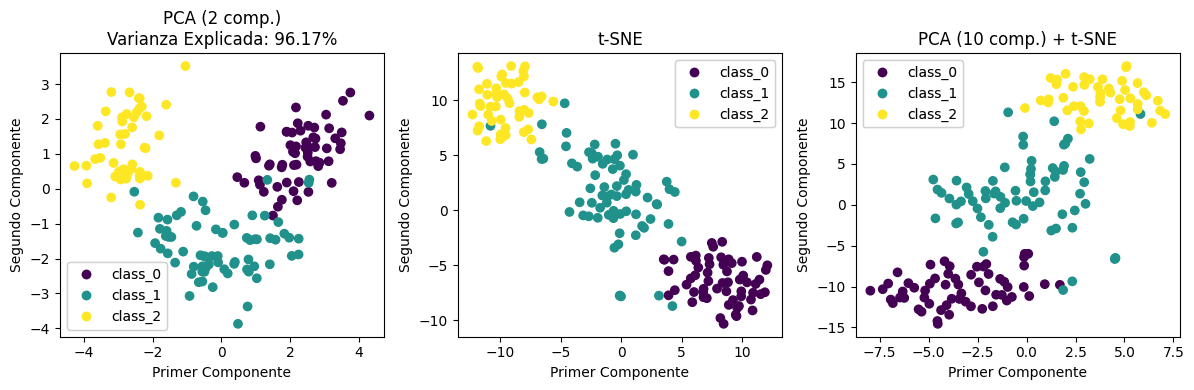

Dimensione inicial (variables): 13
Número de clases: 3
Número de componentes PCA para 95% de varianza: 10


In [ ]:
# Cargar datos vino y analizar
wine = load_wine()
X_wine, y_wine, target_names = wine.data, wine.target, wine.target_names
n_components = compare_pca_tsne(X_wine, y_wine, target_names)

La imagen muestra tres visualizaciones diferentes de un mismo conjunto de datos con tres clases (class_0, class_1 y class_2), utilizando distintas técnicas de reducción de dimensionalidad.

**PCA (2 componentes) (izquierda)**

- Captura el 96.17% de la varianza total con solo dos componentes principales
- Class_0 (púrpura) se concentra principalmente en la parte superior derecha.
- Class_1 (verde-azul) ocupa principalmente la zona media-inferior.
- Class_2 (amarillo) se ubica mayormente en la parte superior izquierda.
- Existe cierta superposición entre las clases, especialmente entre class_0 y class_1.

**t-SNE (centro)**

- Aplicado directamente a los datos originales.
- Class_0 (púrpura) se agrupa en la parte inferior derecha.
- Class_1 (verde-azul) ocupa la zona central.
- Class_2 (amarillo) se concentra en la parte superior izquierda.
- Las fronteras entre clases son más claras, aunque persisten algunos puntos dispersos.

**PCA (10 componentes) + t-SNE (derecha)**

- Combina una reducción inicial a 10 dimensiones mediante PCA seguida de t-SNE.
- Class_0 (púrpura) forma un grupo compacto en la parte inferior.
- Class_1 (verde-azul) ocupa la zona central.
- Class_2 (amarillo) se ubica en la parte superior.
- La separación vertical es particularmente notable, creando tres bandas horizontales bien definidas.

**Insights relevantes**

- Evolución de la separabilidad

  - A pesar de capturar más del 96% de la varianza, PCA no logra una separación óptima de las clases.
  - t-SNE mejora significativamente la visualización de la estructura de clases al enfocarse en preservar relaciones locales.
  - El enfoque híbrido PCA+t-SNE parece ofrecer la mejor separación, sugiriendo que la reducción previa con PCA elimina ruido que podría interferir con t-SNE.

- Estructura lineal vs. no lineal

  - La limitada separación en PCA sugiere que las relaciones entre clases tienen un componente no lineal importante.
  - La mejora con t-SNE confirma que existen patrones no lineales que PCA no puede capturar eficientemente.
  - El hecho de que PCA+t-SNE funcione mejor que t-SNE puro sugiere que hay tanto componentes lineales como no lineales relevantes en los datos.

- Aplicaciones prácticas

  - Para tareas de clasificación con estos datos, algoritmos no lineales probablemente funcionarían mejor.
  - La visualización PCA+t-SNE podría ser útil para identificar posibles valores atípicos o casos mal etiquetados (puntos aislados fuera de su grupo).
  - La clara separación en el enfoque híbrido sugiere que un clasificador relativamente simple podría funcionar bien después de esta transformación.

- Naturaleza de los datos

  - Aunque no se especifica el dominio, la distribución sugiere que podría tratarse de datos de algún tipo de medición física o biológica con tres categorías distintas.
  - La forma en que t-SNE distribuye las clases sugiere que hay una relación ordinal entre ellas (class_2 → class_1 → class_0), posiblemente representando una progresión o espectro.

- Eficiencia computacional

  - El enfoque híbrido PCA+t-SNE no solo mejora la visualización sino que probablemente reduce significativamente el tiempo de computación respecto a t-SNE puro.
  - Esto es particularmente relevante para conjuntos de datos de alta dimensionalidad, donde t-SNE puede ser computacionalmente costoso.

- Esta comparación ilustra claramente la importancia de seleccionar las técnicas de visualización adecuadas según los objetivos del análisis, y cómo diferentes métodos pueden revelar distintos aspectos de la estructura subyacente en los datos.

### **5.4. Resumen Comparación Técnicas**
- **Uso de PCA**:
 - Reducción dimensional preservando relaciones lineales
 - Preprocesamiento para otros algoritmos
 - Cuando la interpretabilidad es importante
 - Conjuntos de datos muy grandes
- **Uso de t-SNE**:
 - Visualización de clusters
 - Exploración de estructuras no lineales
 - Conjuntos de datos pequeños o medianos
 - Cuando el tiempo de computación no es crítico
- **Enfoque Combinado**:
 - PCA para reducción inicial de dimensionalidad
 - t-SNE para visualización final
 - Mejor balance entre tiempo de computación y calidad de visualización